In [1]:
import re
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, year
import matplotlib.pyplot as plt
from collections import defaultdict
from pyspark.sql.functions import explode, col, count
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import numpy as np
import pandas as pd
import pickle
from typing import Dict, Tuple
import os 

In [2]:
# Build a SparkSession
spark = SparkSession.builder \
    .master("spark://master:7077")\
    .appName("Parse CIF files")\
    .config("spark.dynamicAllocation.enabled", "false")\
    .config("spark.driver.host", "10.67.22.219") \
    .config("spark.driver.port","6066")\
    .config("spark.blockManager.port","7088")\
    .config("spark.executor.memory", "3g")\
    .config("spark.executor.cores","4")\
    .config("spark.sql.optimizer.enableRangeJoin", "true")\
    .getOrCreate()

print(spark)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/08 08:16:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
cif_rdd = spark.sparkContext.wholeTextFiles('/data_files/pdb_files/*.cif', minPartitions=12)

### Extracting `_entry.id` from CIF Files 

The following code extracts the `_entry.id` from each File (CIF) in a directory using PySpark. The value of _entry.id identifies the data block and The extracted IDs are stored in a Spark DataFrame for further analysis.

In [4]:
entry_id_pattern = re.compile(r'_entry\.id\s+([][_,.;:"&<>()/\{}\'`~!@#$%A-Za-z0-9*|+-]*)')

def extract_entry_id(file_content):
    entry_id = None
    
    for line in file_content:
        match = entry_id_pattern.search(line)
        if match:
            entry_id = match.group(1)  
            break
    
    return entry_id

# Apply the extract_entry_id function to each file content
entry_id_rdd = cif_rdd.mapValues(lambda content: extract_entry_id(content.splitlines()))

# Convert the result to a DataFrame 
entry_id_rows_rdd = entry_id_rdd.map(lambda file_data: Row(file_name=file_data[0], entry_id=file_data[1]))
entry_id_df = spark.createDataFrame(entry_id_rows_rdd)

# Show the DataFrame with file names and corresponding _entry.id values
entry_id_df.show(truncate=False)

+-----------------------------------+--------+
|file_name                          |entry_id|
+-----------------------------------+--------+
|file:/data_files/pdb_files/1a5j.cif|1A5J    |
|file:/data_files/pdb_files/1a6x.cif|1A6X    |
|file:/data_files/pdb_files/1a91.cif|1A91    |
|file:/data_files/pdb_files/1aa3.cif|1AA3    |
|file:/data_files/pdb_files/1ac0.cif|1AC0    |
|file:/data_files/pdb_files/1adz.cif|1ADZ    |
|file:/data_files/pdb_files/1ag4.cif|1AG4    |
|file:/data_files/pdb_files/1ajy.cif|1AJY    |
|file:/data_files/pdb_files/1akp.cif|1AKP    |
|file:/data_files/pdb_files/1aot.cif|1AOT    |
|file:/data_files/pdb_files/1apc.cif|1APC    |
|file:/data_files/pdb_files/1aq5.cif|1AQ5    |
|file:/data_files/pdb_files/1arq.cif|1ARQ    |
|file:/data_files/pdb_files/1auu.cif|1AUU    |
|file:/data_files/pdb_files/1auz.cif|1AUZ    |
|file:/data_files/pdb_files/1aw6.cif|1AW6    |
|file:/data_files/pdb_files/1axj.cif|1AXJ    |
|file:/data_files/pdb_files/1b75.cif|1B75    |
|file:/data_f

### Extracting _entry.id and Initial Deposition Date from CIF Files

The function `extract_entry_and_deposition_date(file_content)` is designed to extract two key pieces of metadata from Files:

- **_entry.id**: A unique identifier for the entry in the CIF.
- **Initial Deposition Date**: The date when the CIF was initially deposited.


In [6]:
deposition_date_pattern = re.compile(r'[0-9]?[0-9]?[0-9][0-9]-[0-9]?[0-9]-[0-9][0-9]')

def extract_entry_and_deposition_date(file_content):
    
    entry_id = None
    deposition_date = None

    for line in file_content:
        line = line.strip()

        # Extract _entry.id
        if entry_id is None:
            entry_match = entry_id_pattern.search(line)
            if entry_match:
                entry_id = entry_match.group(1)

        # Extract Initial Deposition Date
        if deposition_date is None:
            date_match = deposition_date_pattern.search(line)
            if date_match:
                deposition_date = date_match.group(0)

        if entry_id and deposition_date:
            break

    return entry_id, deposition_date

# Apply the function to extract _entry.id and Initial Deposition Date for each file
entry_date_rdd = cif_rdd.mapValues(lambda content: extract_entry_and_deposition_date(content.splitlines()))

# Convert the result to an RDD of Row objects 
deposition_date_rows_rdd = entry_date_rdd.map(lambda file_data: Row(entry_id=file_data[1][0], deposition_date=file_data[1][1]))

# Convert the RDD to a DataFrame
entry_and_deposition_date_df = spark.createDataFrame(deposition_date_rows_rdd)

#Show the DataFrame with _entry.id and Initial Deposition Date
entry_and_deposition_date_df.show(truncate=False)

+--------+---------------+
|entry_id|deposition_date|
+--------+---------------+
|1A5J    |1998-07-01     |
|1A6X    |1998-10-14     |
|1A91    |1998-07-01     |
|1AA3    |1997-07-23     |
|1AC0    |1997-02-10     |
|1ADZ    |1997-02-19     |
|1AG4    |1998-04-08     |
|1AJY    |1997-09-17     |
|1AKP    |1994-06-20     |
|1AOT    |1997-07-10     |
|1APC    |1994-01-31     |
|1AQ5    |1997-08-07     |
|1ARQ    |1994-01-31     |
|1AUU    |1997-11-12     |
|1AUZ    |1998-07-01     |
|1AW6    |1998-04-15     |
|1AXJ    |1998-01-14     |
|1B75    |2000-01-26     |
|1BAK    |1998-02-25     |
|1BBI    |1991-09-19     |
+--------+---------------+
only showing top 20 rows



### Plotting Research Deposits by Year

Next, we plot the number of research deposits by year to visualize the trend of CIF submissions over time. This will give us insights into the volume of research activity and how it has evolved throughout the years.


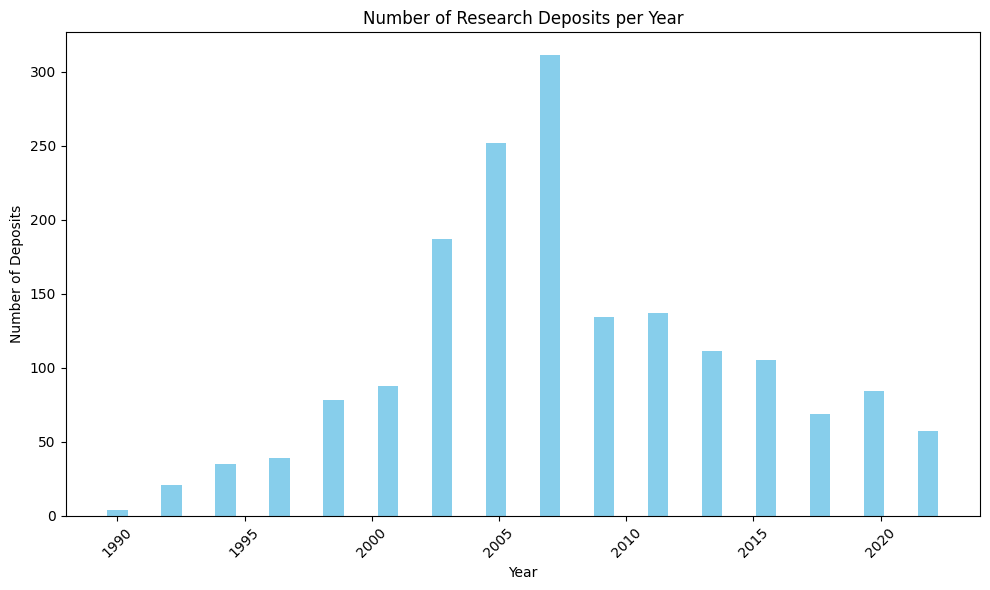

In [9]:
deposition_date_df = entry_and_deposition_date_df.withColumn('deposition_date', col('deposition_date').cast('date'))

# Extract the year from deposition_date
deposition_date_df = deposition_date_df.withColumn('year', year(col('deposition_date')))

num_bins = 16  
bins, counts = deposition_date_df.select("year").rdd.flatMap(lambda x: x).histogram(num_bins)

plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Deposits')
plt.title('Number of Research Deposits per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations

As evident from the plot, the highest number of research deposits occurred in 2007, with around 300 submissions. The period between 2004 and 2007 saw the most significant activity. However, the number of deposits has steadily decreased over time, and in recent years, it has dropped to 50 in the current set of files.


### Extracting Authors and Entry IDs from CIF Files

In this section, we focus on extracting two key pieces of information from the CIF files:

1. **Entry ID**: This is a unique identifier for each CIF entry.
2. **Authors**: The names of the authors associated with each CIF entry.

After extracting these details, the data is structured into a DataFrame where each row contains the entry ID and list of authors. This DataFrame provides a clear overview of the authorship associated with each CIF entry, facilitating further analysis and insights.


In [10]:
# Function to extract authors and entry id 
def extract_authors_and_entry_id(file_content):
    entry_id = None
    authors = []
    inside_loop = False

    for line in file_content:
        line = line.strip()

        # Extract _entry.id
        if entry_id is None:
            entry_match = entry_id_pattern.search(line)
            if entry_match:
                entry_id = entry_match.group(1)

        if "_audit_author.name" in line:
            inside_loop = True
        elif inside_loop:
            if line.startswith("#"):  
                break
            else:
                match = re.match(r"'([^']+)'\s+\d+", line)
                if match:
                    author_name = match.group(1)
                    authors.append(author_name)

    return entry_id, authors

# Apply the function to extract entry ID and authors for each file
entry_author_rdd = cif_rdd.mapValues(lambda content: extract_authors_and_entry_id(content.splitlines()))

# Convert the result to an RDD of Row objects 
authors_rows_rdd = entry_author_rdd.map(lambda file_data: Row(entry_id=file_data[1][0], authors=', '.join(file_data[1][1])))

# Convert the RDD to a DataFrame
authors_df = spark.createDataFrame(authors_rows_rdd)
authors_df = authors_df.dropna()

# Show the DataFrame (first 20 rows)
authors_df.show(truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|entry_id|authors                                                                                                                                                                                                     |
+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1A5J    |Mcintosh, P.B., Carr, M.D., Wollborn, U., Frenkiel, T.A., Feeney, J., Mccormick, J.E., Klempnauer, K.H.                                                                                                     |
|1A6X    |Yao, X., Wei, D., Soden Junior, C., Summers, M.F., Beckett, D.                                                                

### Counting Research Publications by Each Author

Next, we count the number of research publications associated with each author. This involves tallying the total number of entries each author has contributed to and then sorting the authors based on the volume of their work. The sorted data helps us identify the most prolific authors and provides a clear view of author contributions within the dataset.


In [13]:
# Convert the RDD to a DataFrame with columns "entry_id" and "author"
author_df = spark.createDataFrame(authors_rows_rdd, ["entry_id", "author"])
authors_rdd = author_df.select("author").rdd.flatMap(lambda x: x)
author_counts = authors_rdd.countByValue()

sorted_author_counts = sorted(author_counts.items(), key=lambda kv: kv[1], reverse=True)

sorted_author_counts_limited = sorted_author_counts[:20]

header_author = "Author"
header_count = "Count"

max_author_length = max(len(header_author), max(len(author) for author, _ in sorted_author_counts_limited))
max_count_length = max(len(header_count), max(len(str(count)) for _, count in sorted_author_counts_limited))

separator = f"+{'-' * (max_author_length + 2)}+{'-' * (max_count_length + 2)}+"
header_row = f"| {header_author.ljust(max_author_length)} | {header_count.ljust(max_count_length)} |"

print(separator)
print(header_row)
print(separator)
for author, count in sorted_author_counts_limited:
    print(f"| {author.ljust(max_author_length)} | {str(count).rjust(max_count_length)} |")
print(separator)

+---------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
| Author                                                                                                                                                  | Count |
+---------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|                                                                                                                                                         |    51 |
| Nagashima, T., Hayashi, F., Yokoyama, S., RIKEN Structural Genomics/Proteomics Initiative (RSGI)                                                        |    14 |
| He, F., Muto, Y., Inoue, M., Kigawa, T., Shirouzu, M., Terada, T., Yokoyama, S., RIKEN Structural Genomics/Proteomics Initiative (RSGI)                 |    12 |
| Nagata, T., Mu

### Extracting and Analyzing Citation Data

In this step, we extract specific citation-related information from each file, focusing on the following details:

1. **Journal Abbreviation**: The abbreviated name of the journal where the research was published.
2. **Journal Volume**: The volume number of the journal issue in which the research appeared.
3. **Citation Country**: The country associated with the citation.

The extracted data is compiled into a structured format, allowing us to analyze the following:

- **Research Publication Details**: We obtain a comprehensive view of where and how the research was published, including journal details and geographical information.
- **Data Cleaning**: We ensure the dataset is clean by removing any rows with missing values in the critical fields.

The final DataFrame provides a detailed and organized representation of citation data, which can be used for further analysis and visualization of publication trends across different journals and countries.


In [14]:
journal_abbrev_pattern = re.compile(r'_citation\.journal_abbrev\s+([][ \t_(),.;:"&<>/\{}\'`~!@#$%?+=*A-Za-z0-9|^-]+)')
journal_volume_pattern = re.compile(r'_citation\.journal_volume\s+([][ \t_(),.;:"&<>/\{}\'`~!@#$%?+=*A-Za-z0-9|^-]+)')
citation_country_pattern = re.compile(r'_citation\.country\s+([^\s]+)')

def extract_citation_data(file_content):
    entry_id = None
    journal_abbrev = None
    journal_volume = None
    citation_country = None

    for line in file_content:
        line = line.strip()

        # Extract _entry.id
        if entry_id is None:
            entry_match = entry_id_pattern.search(line)
            if entry_match:
                entry_id = entry_match.group(1)

        # Extract _citation.journal_abbrev
        if journal_abbrev is None:
            journal_abbrev_match = journal_abbrev_pattern.search(line)
            if journal_abbrev_match:
                journal_abbrev = journal_abbrev_match.group(1)

        # Extract _citation.journal_volume
        if journal_volume is None:
            journal_volume_match = journal_volume_pattern.search(line)
            if journal_volume_match:
                journal_volume = journal_volume_match.group(1)
        
        # Extract citation_country
        if citation_country is None:
            citation_country_match = citation_country_pattern.search(line)
            if citation_country_match:
                citation_country = citation_country_match.group(1)

    return entry_id, journal_abbrev, journal_volume, citation_country

# Apply the function to extract entry ID, journal abbreviation, citation_country, and volume for each file
entry_citation_rdd = cif_rdd.mapValues(lambda content: extract_citation_data(content.splitlines()))

# Convert the result to an RDD of Row objects
citation_rows_rdd = entry_citation_rdd.map(lambda file_data: Row(entry_id=file_data[1][0], 
                                                        journal_abbrev=file_data[1][1], 
                                                        journal_volume=file_data[1][2],
                                                        citation_country=file_data[1][3]))

# Convert the RDD to a DataFrame
citation_df = spark.createDataFrame(citation_rows_rdd)

# Drop rows with null values
citation_df_cleaned = citation_df.na.drop(subset=["entry_id", "journal_abbrev", "journal_volume", "citation_country"])

# Show the cleaned DataFrame (first 20 rows)
citation_df_cleaned.show(truncate=False)

+--------+-----------------------+--------------+----------------+
|entry_id|journal_abbrev         |journal_volume|citation_country|
+--------+-----------------------+--------------+----------------+
|1A6X    |Biochemistry           |36            |US              |
|1AA3    |J.Mol.Biol.            |274           |UK              |
|1AG4    |J.Mol.Biol.            |271           |UK              |
|1AJY    |Nat.Struct.Biol.       |4             |US              |
|1AUU    |'EMBO J.'              |16            |UK              |
|1AW6    |J.Biomol.NMR           |10            |NE              |
|1AXJ    |Nat.Struct.Biol.       |4             |US              |
|1B75    |'EMBO J.'              |17            |UK              |
|1BBY    |Proc.Natl.Acad.Sci.USA |95            |US              |
|1BF0    |Proteins               |34            |US              |
|1BFM    |J.Mol.Biol.            |255           |UK              |
|1BIP    |Biochemistry           |34            |US           

In [23]:
journals_rdd = citation_df_cleaned.select("journal_abbrev").rdd.flatMap(lambda x: x)
journal_counts = journals_rdd.countByValue()
sorted_journal_counts = sorted(journal_counts.items(), key=lambda kv: kv[1], reverse=True)
sorted_journal_counts_limited = sorted_journal_counts[:20]

header_journal = "Journal Abbrev"
header_count = "Count"

max_journal_length = max(len(header_journal), max(len(str(journal)) for journal, _ in sorted_journal_counts_limited))
max_count_length = max(len(header_count), max(len(str(count)) for _, count in sorted_journal_counts_limited))

separator = f"+{'-' * (max_journal_length + 2)}+{'-' * (max_count_length + 2)}+"
header_row = f"| {header_journal.ljust(max_journal_length)} | {header_count.ljust(max_count_length)} |"

print(separator)
print(header_row)
print(separator)
for journal, count in sorted_journal_counts_limited:
    print(f"| {str(journal).ljust(max_journal_length)} | {str(count).rjust(max_count_length)} |")
print(separator)

+------------------------+-------+
| Journal Abbrev         | Count |
+------------------------+-------+
| 'To be Published'      |   466 |
| J.Biol.Chem.           |   110 |
| J.Mol.Biol.            |   107 |
| Biochemistry           |   102 |
| Proc.Natl.Acad.Sci.USA |    49 |
| 'To Be Published'      |    49 |
| 'Protein Sci.'         |    42 |
| Structure              |    41 |
| Proteins               |    39 |
| 'Nucleic Acids Res.'   |    28 |
| 'Sci Rep'              |    26 |
| 'To be published'      |    24 |
| 'Nat Commun'           |    21 |
| Nat.Struct.Biol.       |    17 |
| Nature                 |    15 |
| J.Biomol.Nmr           |    14 |
| Biochem.J.             |    14 |
| 'EMBO J.'              |    13 |
| Nat.Struct.Mol.Biol.   |    13 |
| J.Am.Chem.Soc.         |    12 |
+------------------------+-------+


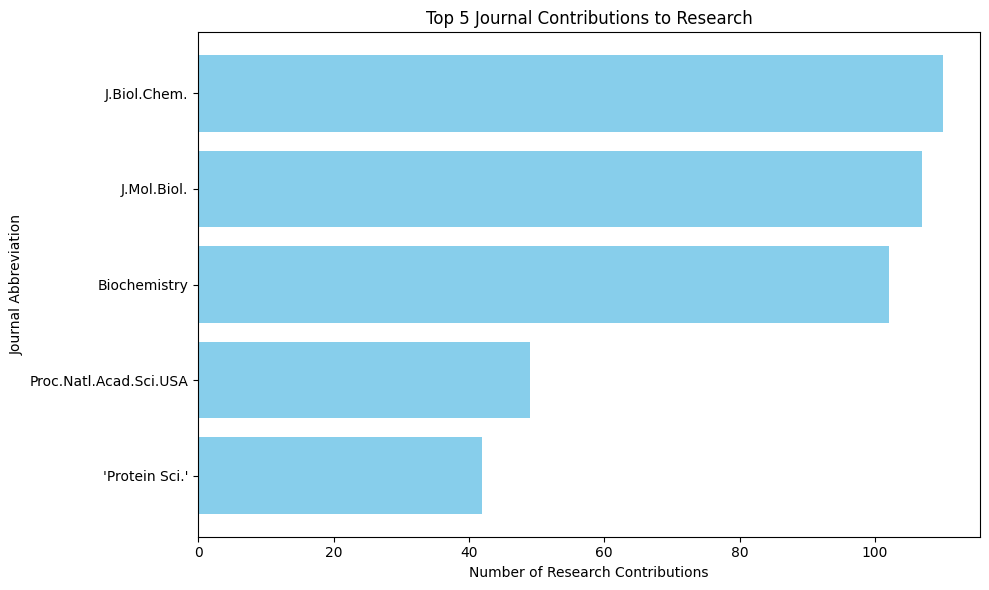

In [25]:
journal_count_pd_df = pd.DataFrame(sorted_journal_counts, columns=['journal_abbrev', 'count'])

# Remove rows where journal_abbrev is "To be Published" and "To Be Published"
journal_count_pd_df = journal_count_pd_df[
    (journal_count_pd_df['journal_abbrev'] != "\'To be Published\'") & 
    (journal_count_pd_df['journal_abbrev'] != "\'To Be Published\'")
]


top_n = 5  
top_journals_pd_df = journal_count_pd_df.sort_values(by='count', ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_journals_pd_df['journal_abbrev'], top_journals_pd_df['count'], color='skyblue')
plt.xlabel('Number of Research Contributions')
plt.ylabel('Journal Abbreviation')
plt.title(f'Top {top_n} Journal Contributions to Research')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Publication Status and Journal Distribution

From the analysis, it is clear that most of the research entries belongs to **Journal of Biological Chemistry (J. Biol. Chem.)** with more than 100 researches within these years. This indicates a significant concentration of research activity within this journal, highlighting its prominence in the dataset.


### Analyzing Research Distribution by Country

In this step, we analyze the distribution of research publications by country. The process involves the following:

- **Counting Publications by Country**: We aggregate the data to count the number of publications associated with each country.
- **Sorting and Ranking**: The countries are then sorted based on the number of publications, and a ranking is assigned to each country.
- **Filtering Results**: We filter the results to exclude the unknown countries and focus on the known countries.

This analysis helps us understand the global distribution of research activities and highlights countries other than the unknown one, providing a clearer view of research contributions from various regions.


In [26]:
countries_rdd = citation_df_cleaned.select("citation_country").rdd.flatMap(lambda x: x)
country_counts = countries_rdd.countByValue()
sorted_country_counts = sorted(country_counts.items(), key=lambda kv: kv[1], reverse=True)

filtered_country_counts = sorted_country_counts[1:]
filtered_country_counts_limited = filtered_country_counts[:20]

header_country = "Citation Country"
header_count = "Count"

max_country_length = max(len(header_country), max(len(str(country)) for country, _ in filtered_country_counts_limited))
max_count_length = max(len(header_count), max(len(str(count)) for _, count in filtered_country_counts_limited))

separator = f"+{'-' * (max_country_length + 2)}+{'-' * (max_count_length + 2)}+"
header_row = f"| {header_country.ljust(max_country_length)} | {header_count.ljust(max_count_length)} |"

print(separator)
print(header_row)
print(separator)
for country, count in filtered_country_counts_limited:
    print(f"| {str(country).ljust(max_country_length)} | {str(count).rjust(max_count_length)} |")
print(separator)

+------------------+-------+
| Citation Country | Count |
+------------------+-------+
| US               |   546 |
| UK               |   328 |
| NE               |    57 |
| CH               |    14 |
| GE               |     7 |
| IX               |     5 |
| DK               |     5 |
| GW               |     3 |
| JP               |     2 |
| CN               |     2 |
| SZ               |     1 |
| AT               |     1 |
+------------------+-------+


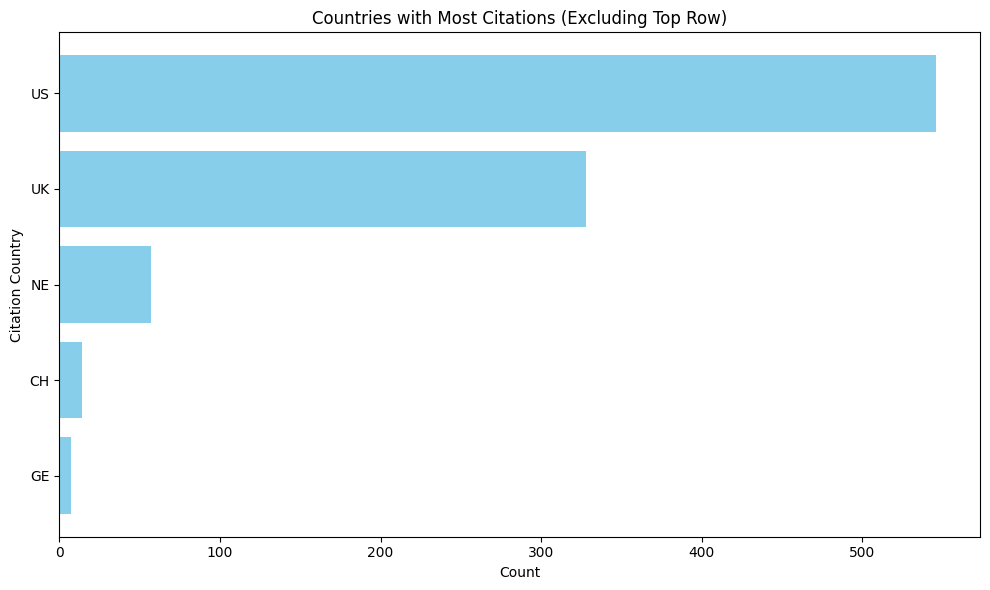

In [27]:
top5_country_counts = filtered_country_counts[:5]
countries = [country for country, count in top5_country_counts]
counts = [count for country, count in top5_country_counts]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(countries, counts, color='skyblue')
plt.xlabel("Count")
plt.ylabel("Citation Country")
plt.title("Countries with Most Citations (Excluding Top Row)")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

As shown in the analysis, the top country is the **USA**, with over 500 research publications, reflecting a significant lead over other countries. The second place is occupied by the **UK**, with more than 300 works. This distribution highlights the substantial research output from these leading countries compared to others in the dataset.

### Extracting and Analyzing Entity Data

In this step, we focus on extracting detailed information about entities from the CIF files. The key data points being extracted include:

1. **Entity Type**: The classification of the entity, such as polymer or non-polymer.
2. **Source Method**: How the entity was sourced, whether from natural sources or genetically manipulated sources.
3. **Formula Weight**: The molecular weight of the entity.

The process involves extracting these details from the CIF file content, filter them by excluding null ones and compiling them into a structured format. The final DataFrame provides a comprehensive view of the entity information, facilitating further analysis and exploration of the data.


In [28]:
# Defines the type of the enti Polymer entities are expected to have corresponding ENTITY_POLY and associated entri Non-polymer entities are expected to have corresponding CHEM_COMP and associated entri Water entities are not expected to have corresponding entries in the ENTITY category.

# The method by which the sample for the entity was produced.
# Entities isolated directly from natural sources (tissues, soil samples etc.) are expected to have further information in the ENTITY_SRC_NAT category. Entities isolated from genetically manipulated sources are expected to have further information in the ENTITY_SRC_GEN category.

entity_type_pattern = re.compile(r'_entity\.type\s+([^\s]+)')
entity_src_method_pattern = re.compile(r'_entity\.src_method\s+([^\s]+)')
formula_weight_pattern = re.compile(r'_entity\.formula_weight\s+(-?(([0-9]+)[.]?|([0-9]*[.][0-9]+))([(][0-9]+[)])?([eE][+-]?[0-9]+)?)')

# Function to extract entry id, entity type, src method, and formula weight
def extract_entity_data(file_content):
    entry_id = None
    entity_type = None
    entity_src_method = None
    formula_weight = None

    for line in file_content:
        line = line.strip()

        # Extract _entry.id
        if entry_id is None:
            entry_match = entry_id_pattern.search(line)
            if entry_match:
                entry_id = entry_match.group(1)

        # Extract _entity.type
        if entity_type is None:
            entity_type_match = entity_type_pattern.search(line)
            if entity_type_match:
                entity_type = entity_type_match.group(1)

        # Extract _entity.src_method
        if entity_src_method is None:
            entity_src_method_match = entity_src_method_pattern.search(line)
            if entity_src_method_match:
                entity_src_method = entity_src_method_match.group(1)

        # Extract _entity.formula_weight
        if formula_weight is None:
            formula_weight_match = formula_weight_pattern.search(line)
            if formula_weight_match:
                formula_weight = formula_weight_match.group(1)

        if entry_id and entity_type and entity_src_method and formula_weight:
            break

    return entry_id, entity_type, entity_src_method, formula_weight

# Apply the function to extract entry ID, entity type, src method, and formula weight for each file
entry_entity_rdd = cif_rdd.mapValues(lambda content: extract_entity_data(content.splitlines()))

# Convert the result to an RDD of Row objects
entry_entity_rows_rdd = entry_entity_rdd.map(lambda file_data: Row(entry_id=file_data[1][0], 
                                                      entity_type=file_data[1][1], 
                                                      entity_src_method=file_data[1][2],
                                                      formula_weight=file_data[1][3]))

# Convert the RDD to a DataFrame
entry_entity_df = spark.createDataFrame(entry_entity_rows_rdd)

# Drop rows with null values
entry_entity_df = entry_entity_df.dropna()

# Show the DataFrame (first 20 rows)
entry_entity_df.show(truncate=False)

+--------+-----------+-----------------+--------------+
|entry_id|entity_type|entity_src_method|formula_weight|
+--------+-----------+-----------------+--------------+
|1A5J    |polymer    |man              |12958.        |
|1A6X    |polymer    |man              |9341.         |
|1A91    |polymer    |man              |8259.         |
|1AA3    |polymer    |nat              |7108.         |
|1ADZ    |polymer    |man              |8379.         |
|1AG4    |polymer    |man              |11296.        |
|1AKP    |polymer    |man              |10972.        |
|1APC    |polymer    |man              |11799.        |
|1AQ5    |polymer    |man              |5393.         |
|1ARQ    |polymer    |man              |6238.         |
|1AUU    |polymer    |man              |6365.         |
|1AUZ    |polymer    |man              |12874.        |
|1B75    |polymer    |nat              |10713.        |
|1BAK    |polymer    |man              |14214.        |
|1BBI    |polymer    |man              |7880.   

### Distribution of Entity Source Methods

In this analysis, we examine the distribution of different source methods for entities in the dataset. Specifically, we are interested in:

**Source Methods**: The categories of how entities were isolated or obtained, such as:
   - **man**: Entities isolated from genetically manipulated sources.
   - **nat**: Entities isolated from natural sources.
   - **syn**: Entities obtained synthetically.

The resulting pie chart provides a clear visual representation of how entities are distributed according to their source methods, highlighting the relative contributions of each category in the dataset.


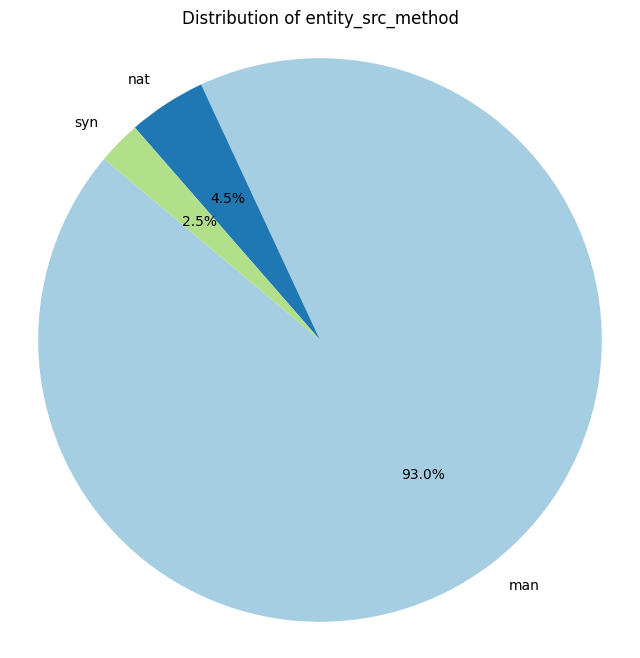

In [29]:
columns = ["id", "entity_src_method"]

# Convert the DataFrame's 'entity_src_method' column to an RDD of methods
methods_rdd = entry_entity_df.select("entity_src_method").rdd.flatMap(lambda x: x)

# Count the occurrences of each method using countByValue 
src_method_counts = methods_rdd.countByValue()

# Extract the labels and counts for plotting
labels = list(src_method_counts.keys())
counts = list(src_method_counts.values())

# Calculate percentages
total_count = sum(counts)
percentages = [(count / total_count) * 100 for count in counts]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of entity_src_method')
plt.axis('equal')  
plt.show()

### Analysis of Entity Source Methods

As depicted in the pie chart, **93%** of the entities are classified as being isolated from genetically manipulated sources. This category, labeled as **"man"** (short for "man-made" or "genetically manipulated"), represents entities that have been derived from sources that have undergone genetic modifications.

This significant proportion indicates a strong focus on genetically manipulated entities in the dataset, highlighting their prevalence compared to entities sourced from natural or synthetic origins.


### Analysis of Formula Weights

This step involves analyzing the distribution of formula weights for the entities in the dataset. We focus on two types of visualizations:

- **Histogram**: This plot shows the frequency distribution of formula weights. It helps us understand the spread and common ranges of molecular weights across the dataset.

- **Box Plot**: This plot provides a summary of the formula weight distribution, highlighting key statistical features such as the median, quartiles, and potential outliers.



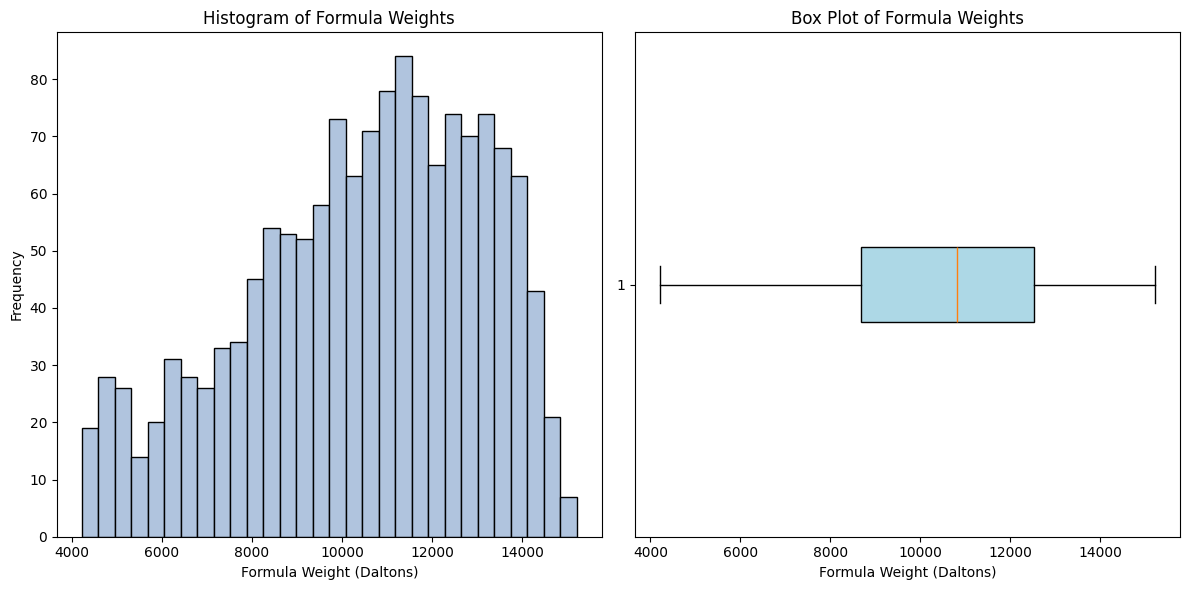

In [36]:
weight_df = entry_entity_df.withColumn("formula_weight", entry_entity_df["formula_weight"].cast("float"))

# Collect the data as a Pandas DataFrame for plotting
formula_weights = weight_df.select("formula_weight").dropna().toPandas()

plt.figure(figsize=(12, 6))

# Histogram of formula_weight
plt.subplot(1, 2, 1)
plt.hist(formula_weights['formula_weight'], bins=30, color='lightsteelblue', edgecolor='black')
plt.title('Histogram of Formula Weights')
plt.xlabel('Formula Weight (Daltons)')
plt.ylabel('Frequency')

# Box plot of formula_weight
plt.subplot(1, 2, 2)
plt.boxplot(formula_weights['formula_weight'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Formula Weights')
plt.xlabel('Formula Weight (Daltons)')

plt.tight_layout()
plt.show()

### Analysis of Formula Weights

The histogram and box plot provide a distribution of formula weights (in Daltons) across the dataset:

- The dataset shows a balanced and symmetric distribution of formula weights with no extreme outliers.
- The majority of weights fall within 7,000 to 13,000 Daltons, centered around a median of 10,000 Daltons.

This part of the code produces a DataFrame (`entity_poly_df`) with the following columns:
1. **`entry_id`** 
2. **`entity_poly_type`:** Type of polymer (e.g., polypeptide, DNA, RNA) that helps categorize polymers (e.g., proteins, nucleic acids).
3. **`sequence`:** One-letter code sequence of the polymer that enables sequence-based analyses, such as alignment, structure prediction, or classification.

In [31]:
# function to extract sequences
def extract_sequence(file_content):
    sequence = ''
    entry_id = None
    entity_poly_type = None

    for i, line in enumerate(file_content):
        line = line.replace('\n', '')

        if entry_id is None:
            entry_id_match = re.search(r'_entry\.id\s+([A-Za-z0-9_]+)', line)
            if entry_id_match:
                entry_id = entry_id_match.group(1)

        # Extract _entity_poly.type
        if entity_poly_type is None:
            entity_poly_type_match = re.search(r'_entity_poly\.type\s+([_,.;:"&<>()/\{}\'`~!@#$%A-Za-z0-9*|+-]*)', line)
            if entity_poly_type_match:
                entity_poly_type = entity_poly_type_match.group(1)

        # Matching the sequence line
        seq_line = re.findall(r'^_entity_poly\.pdbx_seq_one_letter_code_can\s{3}.*', line)
        if len(seq_line) != 0:
            seq_line_0 = re.findall(r'^_entity_poly\.pdbx_seq_one_letter_code_can\s{3}\S.*', line)
            if len(seq_line_0) != 0:
                sequence = seq_line[0].split('can')[1].replace('\n', '').replace(' ', '')
            else:
                sequence = file_content[i+1].split(' ')[0].replace(';', '').replace('\n', '').replace(' ', '')
                
                if ';' not in file_content[i+2]:
                    sequence += file_content[i+2].split(' ')[0].replace('\n', '').replace(' ', '')
                elif ';' not in file_content[i+3]:
                    sequence += file_content[i+3].split(' ')[0].replace('\n', '').replace(' ', '')
    
    return sequence, entity_poly_type, entry_id

# Extract both entity_poly and sequence 
sequence_rdd = cif_rdd.mapValues(lambda content: extract_sequence(content.splitlines()))

entity_poly_rows_rdd = sequence_rdd.map(lambda file_data: Row(entry_id=file_data[1][2], entity_poly_type=file_data[1][1], sequence= file_data[1][0]))

entity_poly_df = spark.createDataFrame(entity_poly_rows_rdd)

entity_poly_df.show(truncate=False)


+--------+----------------+--------------------------------------------------------------------------------------------------------------------------+
|entry_id|entity_poly_type|sequence                                                                                                                  |
+--------+----------------+--------------------------------------------------------------------------------------------------------------------------+
|1A5J    |'polypeptide(L)'|GIPDLVKGPWTKEEDQKVIELVKKYGTKQWTLIAKHLKGRLGKQCRERWHNHLNPEVKKSSWTEEEDRIIFEAHKVLGNRWAEIAKLLPGRTDNAVKNHWNSTIKRKVDT            |
|1A6X    |'polypeptide(L)'|MEAPAAAEISGHIVRSPMVGTFYRTPSPDAKAFIEVGQKVNVGDTLCIVEAMKMMNQIEADKSGTVKAILVESGQPVEFDEPLVVIE                                   |
|1A91    |'polypeptide(L)'|MENLNMDLLYMAAAVMMGLAAIGAAIGIGILGGKFLEGAARQPDLIPLLRTQFFIVMGLVDAIPMIAVGLGLYVMFAVA                                           |
|1AA3    |'polypeptide(L)'|INFYGELVDLGVKEKLIEKAGAWYSYKGEKIGQGKANATAWLKDNPETAKEIEKKVRELLLSN    

This part produces a sorted DataFrame with Single-letter code of amino acids and their total occurrences across all sequences in the CIF files, which enables insights into the prevalence of specific amino acids, that can be useful for studying protein structure and function and also identifying patterns in amino acid composition.

In [32]:
def extract_sequence(lines):
    return "\n".join(lines)

# Create an RDD of (filename, sequence) pairs.
sequence_rdd = cif_rdd.mapValues(lambda content: extract_sequence(content.splitlines()))

# Define the function to count amino acids in a given sequence.
def count_amino_acids(sequence):
    amino_acid_counts = defaultdict(int)
    
    # Regular expression for standard amino acids
    pattern = r'([A-Z])'
    matches = re.findall(pattern, sequence)
    
    for match in matches:
        if match[0]:  # Standard amino acid
            amino_acid_counts[match[0]] += 1
        elif match[1]:  # Non-standard amino acid
            amino_acid_counts[match[1]] += 1
    
    return amino_acid_counts

# Count amino acids in all sequences
amino_acid_rdd = sequence_rdd.map(lambda file_data: count_amino_acids(file_data[1]))

# Aggregate the counts for all files
total_amino_acid_counts = amino_acid_rdd.reduce(
    lambda x, y: {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}
)

# Create an RDD of Rows from the aggregated counts using parallelize
amino_acid_rows = [Row(Amino_Acid=aa, Count=count) for aa, count in total_amino_acid_counts.items()]
amino_acid_rows_rdd = spark.sparkContext.parallelize(amino_acid_rows)
amino_acid_df = spark.createDataFrame(amino_acid_rows_rdd)

sorted_amino_acid_df = amino_acid_df.orderBy("Count", ascending=False)

sorted_amino_acid_df.show(truncate=False)

+----------+---------+
|Amino_Acid|Count    |
+----------+---------+
|A         |191821440|
|H         |93816954 |
|O         |72073692 |
|T         |66352812 |
|L         |56589455 |
|M         |55013440 |
|C         |53916890 |
|G         |42795377 |
|E         |38714355 |
|S         |30434446 |
|R         |29324802 |
|B         |27744103 |
|N         |25381916 |
|Y         |19848319 |
|U         |19096196 |
|D         |15923364 |
|P         |15404457 |
|I         |10265364 |
|V         |7039086  |
|Z         |3238807  |
+----------+---------+
only showing top 20 rows



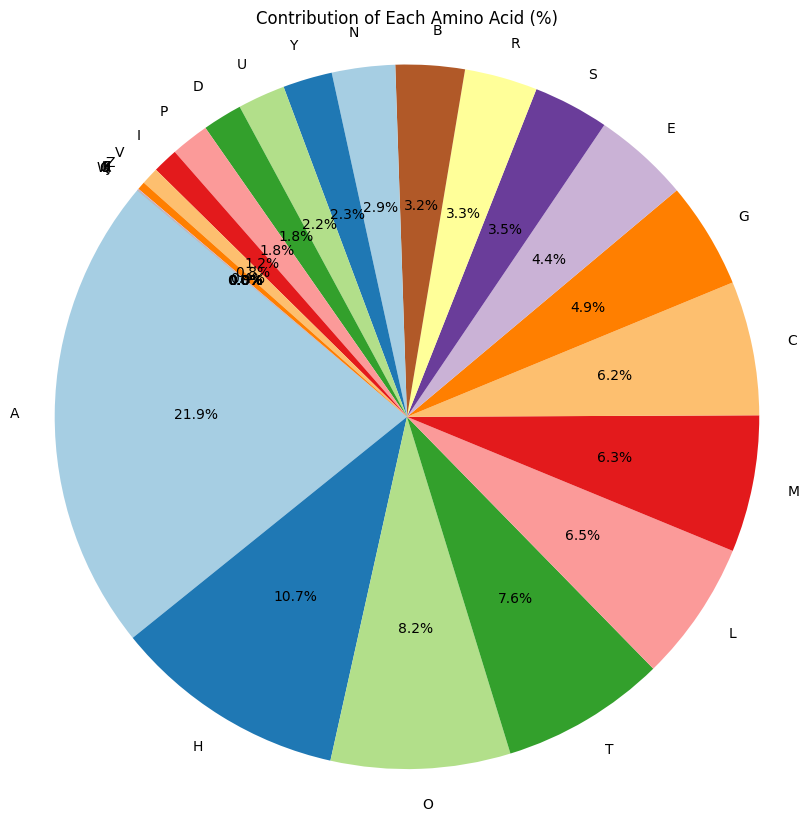

In [33]:
total_count = sum(total_amino_acid_counts.values())
sorted_amino_acid_counts = sorted(total_amino_acid_counts.items(), key=lambda kv: kv[1], reverse=True)
amino_acids, counts = zip(*sorted_amino_acid_counts)

# Compute the percentage contribution of each amino acid
percentages = [(count / total_count) * 100 for count in counts]

# Plot a pie chart to visualize the percentage contribution of each amino acid
plt.figure(figsize=(10, 10))
plt.pie(percentages, labels=amino_acids, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Contribution of Each Amino Acid (%)")
plt.axis('equal')  
plt.show()

### Overview:
The pie chart illustrates the percentage contribution of each amino acid across all sequences in the dataset. 
1. **Dominant Amino Acid:**
   - **Alanine (A):** Constitutes the largest share, contributing approximately **21.9%** to the total, making it the most frequent amino acid in the dataset.


2. **Significant Contributors:**
   - **Histidine (H):** Accounts for **10.7%**, indicating its prominence in the sequences.
   - **Others (O), Threonine (T), and Leucine (L):** Each contributes between **6.5% and 8.2%**.


3. **Less Frequent Amino Acids:**
   - Several amino acids, such as **Isoleucine (I)** and **Valine (V)**, appear in smaller proportions, contributing less than **2%**.


In [38]:
spark.stop()